In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.model_selection import train_test_split
import os
from torch.utils.data import ConcatDataset
from PIL import Image
import cv2 
import tensorflow as tf
from transformers import TFViTModel
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report
from torch.utils.data import random_split
import random
from tensorflow.keras.models import load_model
import unicodedata
from collections import Counter
from torchvision import transforms
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import  f1_score
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.applications import VGG16
from keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import class_weight

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)




In [3]:
Data = pd.read_csv('combined_image_label_dataset.csv')
Data

,patient_name,path,histo_label,global_id
0,B1_0,0_001.Jpg,1,0
1,B1_0,0_002.Jpg,1,1
2,B1_0,0_003.Jpg,1,2
3,B1_0,0_004.Jpg,1,3
4,B1_0,0_005.Jpg,1,4
...,...,...,...,...
8495,B2_241,241_019_180801.Jpg,1,8495
8496,B2_241,241_020_180801.Jpg,1,8496
8497,B2_241,241_021_180801.Jpg,1,8497
8498,B2_241,241_022_180801.Jpg,1,8498


In [4]:
dataframe1=pd.read_excel('histo_label_0.xlsx')
dataframe1

,patient_name,path,histo_label,global_id
0,B1_1,1_001.Jpg,0,6
1,B1_1,1_002.Jpg,0,7
2,B1_1,1_003.Jpg,0,8
3,B1_1,1_004.Jpg,0,9
4,B1_1,1_005.Jpg,0,10
...,...,...,...,...
2990,B2_240,240_007_182509.Jpg,0,8480
2991,B2_240,240_008_182509.Jpg,0,8481
2992,B2_240,240_009_182509.Jpg,0,8482
2993,B2_240,240_010_182509.Jpg,0,8483


In [5]:
dataframe2=pd.read_excel('histo_label_1.xlsx')
dataframe2

,patient_name,path,histo_label,global_id
0,B1_0,0_001.Jpg,1,0
1,B1_0,0_002.Jpg,1,1
2,B1_0,0_003.Jpg,1,2
3,B1_0,0_004.Jpg,1,3
4,B1_0,0_005.Jpg,1,4
...,...,...,...,...
5500,B2_241,241_019_180801.Jpg,1,8495
5501,B2_241,241_020_180801.Jpg,1,8496
5502,B2_241,241_021_180801.Jpg,1,8497
5503,B2_241,241_022_180801.Jpg,1,8498


## Image Loading

In [6]:
image_folder2 = "C:/Users/nalla/OneDrive/ドキュメント/Research data sets/dataset"
image_paths2 = [
    os.path.join(image_folder2, file)
    for file in os.listdir(image_folder2)
    if file.lower().endswith('.jpg')
]

print(f"Total images found: {len(image_paths2)}")
image_data2 = []
valid_path2=[]
for idx, path in enumerate(image_paths2):
    try:
        img = Image.open(path).convert('RGB')  
        img_resized = img.resize((224, 224))   
        img_array = np.array(img_resized)      
        image_data2.append(img_array)           
        valid_path2.append(os.path.basename(path))
        
        
        if (idx + 1) % 500 == 0:
            print(f"{idx + 1} images loaded...")

    except Exception as e:
        print(f"Error loading {path}: {e}")


image_data2 = np.array(image_data2)

print(f"\n✅ All images loaded and stored! Shape: {image_data2.shape}")



Total images found: 8508
500 images loaded...
1000 images loaded...
1500 images loaded...
2000 images loaded...
2500 images loaded...
3000 images loaded...
3500 images loaded...
4000 images loaded...
4500 images loaded...
5000 images loaded...
5500 images loaded...
6000 images loaded...
6500 images loaded...
7000 images loaded...
7500 images loaded...
8000 images loaded...
8500 images loaded...

✅ All images loaded and stored! Shape: (8508, 224, 224, 3)


## Image Path Verification

In [7]:
# === 1. Helper to normalize filenames ===
def clean_filename(p):
    name = os.path.basename(p)
    name = unicodedata.normalize('NFKC', name).strip().lower()  # Normalize unicode + lowercase
    name = os.path.splitext(name)[0] + '.jpg'  # Force .jpg extension
    return name

# === 2. Combine image arrays and paths ===
all_images =  image_data2
valid_paths =  valid_path2

# === 3. Normalize valid image filenames ===
valid_filenames = [clean_filename(p) for p in valid_paths]

# === 4. Normalize DataFrame path column ===
dataframe1['path'] = dataframe1['path'].apply(clean_filename)

# === 5. Check for duplicates ===
dupes = [item for item, count in Counter(valid_filenames).items() if count > 1]
print(f"🔁 Duplicate filenames in valid_paths: {len(dupes)}")

# === 6. Create dict from filename → image ===
image_dict = dict(zip(valid_filenames, all_images))  # if duplicates exist, only last one is kept

# === 7. Filter and match DataFrame to available images ===
filtered_df = dataframe1[dataframe1['path'].isin(image_dict.keys())].reset_index(drop=True)
print(f"✅ Matched: {filtered_df.shape[0]} out of {dataframe1.shape[0]}")
filtered_images = [image_dict[clean_filename(p)] for p in filtered_df['path']]
image_data0 = np.array(filtered_images)  # This is a numpy array of images
labels0 = filtered_df['histo_label'].values 

# === 8. Debug unmatched entries ===
unmatched_paths = set(dataframe1['path']) - set(image_dict.keys())
if unmatched_paths:
    print(f"❌ Unmatched images: {len(unmatched_paths)}")
    print("Sample unmatched:", list(unmatched_paths)[:10])
    

    
dataframe2['path'] = dataframe2['path'].apply(clean_filename)

# === 5. Check for duplicates ===
dupes = [item for item, count in Counter(valid_filenames).items() if count > 1]
print(f"🔁 Duplicate filenames in valid_paths: {len(dupes)}")

# === 6. Create dict from filename → image ===
image_dict = dict(zip(valid_filenames, all_images))  # if duplicates exist, only last one is kept

# === 7. Filter and match DataFrame to available images ===
filtered_df1 = dataframe2[dataframe2['path'].isin(image_dict.keys())].reset_index(drop=True)
print(f"✅ Matched: {filtered_df1.shape[0]} out of {dataframe2.shape[0]}")
filtered_images2 = [image_dict[clean_filename(p)] for p in filtered_df1['path']]
image_data1 = np.array(filtered_images2)  # This is a numpy array of images
labels1 = filtered_df1['histo_label'].values 


# === 8. Debug unmatched entries ===
unmatched_paths = set(dataframe2['path']) - set(image_dict.keys())
if unmatched_paths:
    print(f"❌ Unmatched images: {len(unmatched_paths)}")
    print("Sample unmatched:", list(unmatched_paths)[:10])
    
combined_dataset0 = list(zip(image_data0, labels0)) 
combined_dataset1 = list(zip(image_data1, labels1)) 

🔁 Duplicate filenames in valid_paths: 0
✅ Matched: 2214 out of 2995
❌ Unmatched images: 781
Sample unmatched: ['136_018.jpg', '583_038.jpg', '149_047.jpg', '180_011.jpg', '168_003.jpg', '209_014.jpg', '277_009.jpg', '343_012.jpg', '333_010.jpg', '176_008.jpg']
🔁 Duplicate filenames in valid_paths: 0
✅ Matched: 3679 out of 5505
❌ Unmatched images: 1826
Sample unmatched: ['490_031.jpg', '34_013.jpg', '356_010.jpg', '437_012.jpg', '244_012.jpg', '82_010.jpg', '442_014.jpg', '267_016.jpg', '109_005.jpg', '195_007.jpg']


In [8]:

df_combined0 = pd.DataFrame(combined_dataset0, columns=['image', 'label'])
df_combined1 = pd.DataFrame(combined_dataset1, columns=['image', 'label'])



In [9]:


df_combined0 = pd.DataFrame(combined_dataset0, columns=['image', 'label'])
assert df_combined0['image'].isnull().sum() == 0, "Some images are None!"
your_transform_here = transforms.Compose([
    transforms.ToPILImage(),  
    transforms.Resize((224, 224)),  
    transforms.ToTensor()  
])
df_combined1 = pd.DataFrame(combined_dataset1, columns=['image', 'label'])
assert df_combined0['image'].isnull().sum() == 0, "Some images are None!"
your_transform_here = transforms.Compose([
    transforms.ToPILImage(),  
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),  
   
])


class ImageDatasetFromDataFrame(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        image = self.dataframe.iloc[idx]['image']
        label = self.dataframe.iloc[idx]['label']
        if isinstance(image, np.ndarray):
            if self.transform:
                image = self.transform(image)


        return image, torch.tensor(label, dtype=torch.long)


custom_dataset0 = ImageDatasetFromDataFrame(df_combined0, transform=your_transform_here)
sample_image, sample_label = custom_dataset0[0]
print(f"✅ Sample loaded: image shape = {sample_image.shape}, label = {sample_label}")
            
custom_dataset1 = ImageDatasetFromDataFrame(df_combined1, transform=your_transform_here)
sample_image, sample_label = custom_dataset1[0]
print(f"✅ Sample loaded: image shape = {sample_image.shape}, label = {sample_label}")


✅ Sample loaded: image shape = torch.Size([3, 224, 224]), label = 0
✅ Sample loaded: image shape = torch.Size([3, 224, 224]), label = 1


## Data Spliting

In [10]:

total_size_0 = len(custom_dataset0)
total_size_1 = len(custom_dataset1)
splits = {
    '60-20-20': [0.6, 0.2, 0.2],
    '70-15-15': [0.7, 0.15, 0.15],
    '65-15-20': [0.65, 0.15, 0.2],
    '75-15-10': [0.75, 0.15, 0.1],
    '80-10-10': [0.8, 0.1, 0.1],
}

split_70 = splits['70-15-15']
train_len_70_0 = int(split_70[0] * total_size_0)
val_len_70_0 = int(split_70[1] * total_size_0)
test_len_70_0 = total_size_0 - train_len_70_0 - val_len_70_0
train_set_0_701515, val_set_0_701515, test_set_0_701515 = random_split(custom_dataset0, [train_len_70_0, val_len_70_0, test_len_70_0])
print(f"✅ Split done — Train: {len(train_set_0_701515)}, Validation: {len(val_set_0_701515)}, Test: {len(test_set_0_701515)}")

train_len_70_1 = int(split_70[0] * total_size_1)
val_len_70_1 = int(split_70[1] * total_size_1)
test_len_70_1 = total_size_1 - train_len_70_1 - val_len_70_1
train_set_1_701515, val_set_1_701515, test_set_1_701515 = random_split(custom_dataset1, [train_len_70_1, val_len_70_1, test_len_70_1])
print(f"✅ Split done — Train: {len(train_set_1_701515)}, Validation: {len(val_set_1_701515)}, Test: {len(test_set_1_701515)}")



✅ Split done — Train: 1549, Validation: 332, Test: 333
✅ Split done — Train: 2575, Validation: 551, Test: 553


In [11]:
train_set_701515=train_set_0_701515 +train_set_1_701515
test_set_701515= test_set_0_701515+test_set_1_701515
val_set_701515=val_set_0_701515+val_set_1_701515


## Data Augmentation

In [12]:

train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10),  
  transforms.ToTensor() 
])


test_val_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])





In [13]:
train_set_0_701515.dataset.transform = train_transform
val_set_0_701515.dataset.transform = test_val_transform
test_set_0_701515.dataset.transform = test_val_transform
train_set_1_701515.dataset.transform = train_transform
val_set_1_701515.dataset.transform = test_val_transform
test_set_1_701515.dataset.transform = test_val_transform

augmented_train_set_701515=train_set_0_701515+train_set_1_701515
combined_val_701515=val_set_0_701515+val_set_1_701515
combined_test_701515=test_set_0_701515+test_set_1_701515




In [14]:
aug_images_701515 = []
aug_labels_701515 = []



for img, label in augmented_train_set_701515:
    aug_images_701515.append(img)
    aug_labels_701515.append(label)



# Count current labels
counter = Counter(aug_labels_701515)
class0_indices = [i for i, lbl in enumerate(aug_labels_701515) if lbl == 0]
class1_count = aug_labels_701515.count(1)
class0_count = aug_labels_701515.count(0)

# Oversample class 0 to match class 1
extra_0_needed = class1_count - class0_count
if extra_0_needed > 0:
    sampled_indices = random.choices(class0_indices, k=extra_0_needed)
    for idx in sampled_indices:
        aug_images_701515.append(aug_images_701515[idx])
        aug_labels_701515.append(aug_labels_701515[idx])


augmented_df_701515 = pd.DataFrame({
    'image': aug_images_701515,
    'label': aug_labels_701515
})
print(f"Images: {len(aug_images_701515)}, Labels: {len(aug_labels_701515)}")







Images: 5150, Labels: 5150


In [15]:
aug_images_701515[0].shape

torch.Size([3, 224, 224])

In [16]:

augmented_dataset_701515 = ImageDatasetFromDataFrame(augmented_df_701515, transform=train_transform)




In [17]:



train_df0_7030, test_df0_7030 = train_test_split(df_combined0, test_size=0.3, shuffle=True)
train_set0_7030 = ImageDatasetFromDataFrame(train_df0_7030, transform=your_transform_here)
test_image0_7030=test_df0_7030['image']
test_label0_7030=test_df0_7030['label']
test_labels0_7030= test_label0_7030.to_frame(name='label')


train_df1_7030, test_df1_7030 = train_test_split(df_combined1, test_size=0.3, shuffle=True)
train_set1_7030 = ImageDatasetFromDataFrame(train_df1_7030, transform=your_transform_here)
test_image1_7030=test_df1_7030['image']
test_label1_7030=test_df1_7030['label']
test_labels1_7030 = test_label1_7030.to_frame(name='label')





# Label Testing

In [18]:

final_train_7030=ConcatDataset([augmented_dataset_701515,train_set0_7030,train_set1_7030])
final_test_images_7030= pd.concat([test_image0_7030,test_image1_7030])
final_test_labels_7030=pd.concat([test_labels0_7030,test_labels1_7030])
# If your labels are Series
if isinstance(final_test_labels_7030, pd.Series):
    final_test_labels_7030 = final_test_labels_7030.to_frame()  # Converts Series to DataFrame
    final_test_labels_7030.columns = ['label']  # Ensure correct column name

final_test_labels_7030=ImageDatasetFromDataFrame(final_test_labels_7030, transform=your_transform_here)
print(final_test_labels_7030) 
# Access the dataframe directly from the dataset object
df_7030 = getattr(final_test_labels_7030, 'dataframe', None)
print(df_7030)
# Check if it is a DataFrame and contains the 'label' column
if isinstance(df_7030, pd.DataFrame) and 'label' in df_7030.columns:
    print("✅ Test set has labels.")
else:
    print("❌ Missing labels or not a DataFrame.")

      label
1466      0
1418      0
581       0
1517      0
1231      0
...     ...
837       1
886       1
387       1
974       1
2339      1

[1769 rows x 1 columns]
✅ Test set has labels.


In [19]:
for i, ds in enumerate(final_train_7030.datasets):
    if hasattr(ds, 'dataframe') and 'label' in ds.dataframe.columns:
        print(f"Dataset {i} ✅ has labels.")
    else:
        print(f"Dataset {i} ❌ missing labels.")

Dataset 0 ✅ has labels.
Dataset 1 ✅ has labels.
Dataset 2 ✅ has labels.


In [20]:
# Filter class 0 samples
class0_data = [sample for sample in final_train_7030 if sample[1].item() == 0]
# Randomly oversample 1026 class 0 samples
extra_0_samples = random.choices(class0_data, k=1026)
# Combine with existing training set
final_train_7030 = final_train_7030 + extra_0_samples


C:\Users\nalla\AppData\Local\Temp\ipykernel_23128\2180272878.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return image, torch.tensor(label, dtype=torch.long)


In [21]:
# Filter class 0 samples
class0_data = [sample for sample in combined_val_701515 if sample[1].item() == 0]
# Randomly oversample 1026 class 0 samples
extra_0_samples = random.choices(class0_data, k=219)
# Combine with existing training set
combined_val_701515 = combined_val_701515 + extra_0_samples


In [22]:
labels = [label for _, label in combined_val_701515]
Counter(label.item() for _, label in combined_val_701515)


Counter({0: 551, 1: 551})

C:\Users\nalla\AppData\Local\Temp\ipykernel_23128\2180272878.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return image, torch.tensor(label, dtype=torch.long)


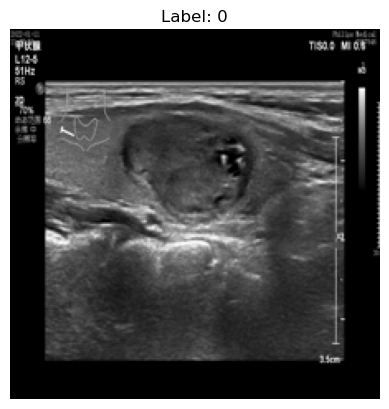

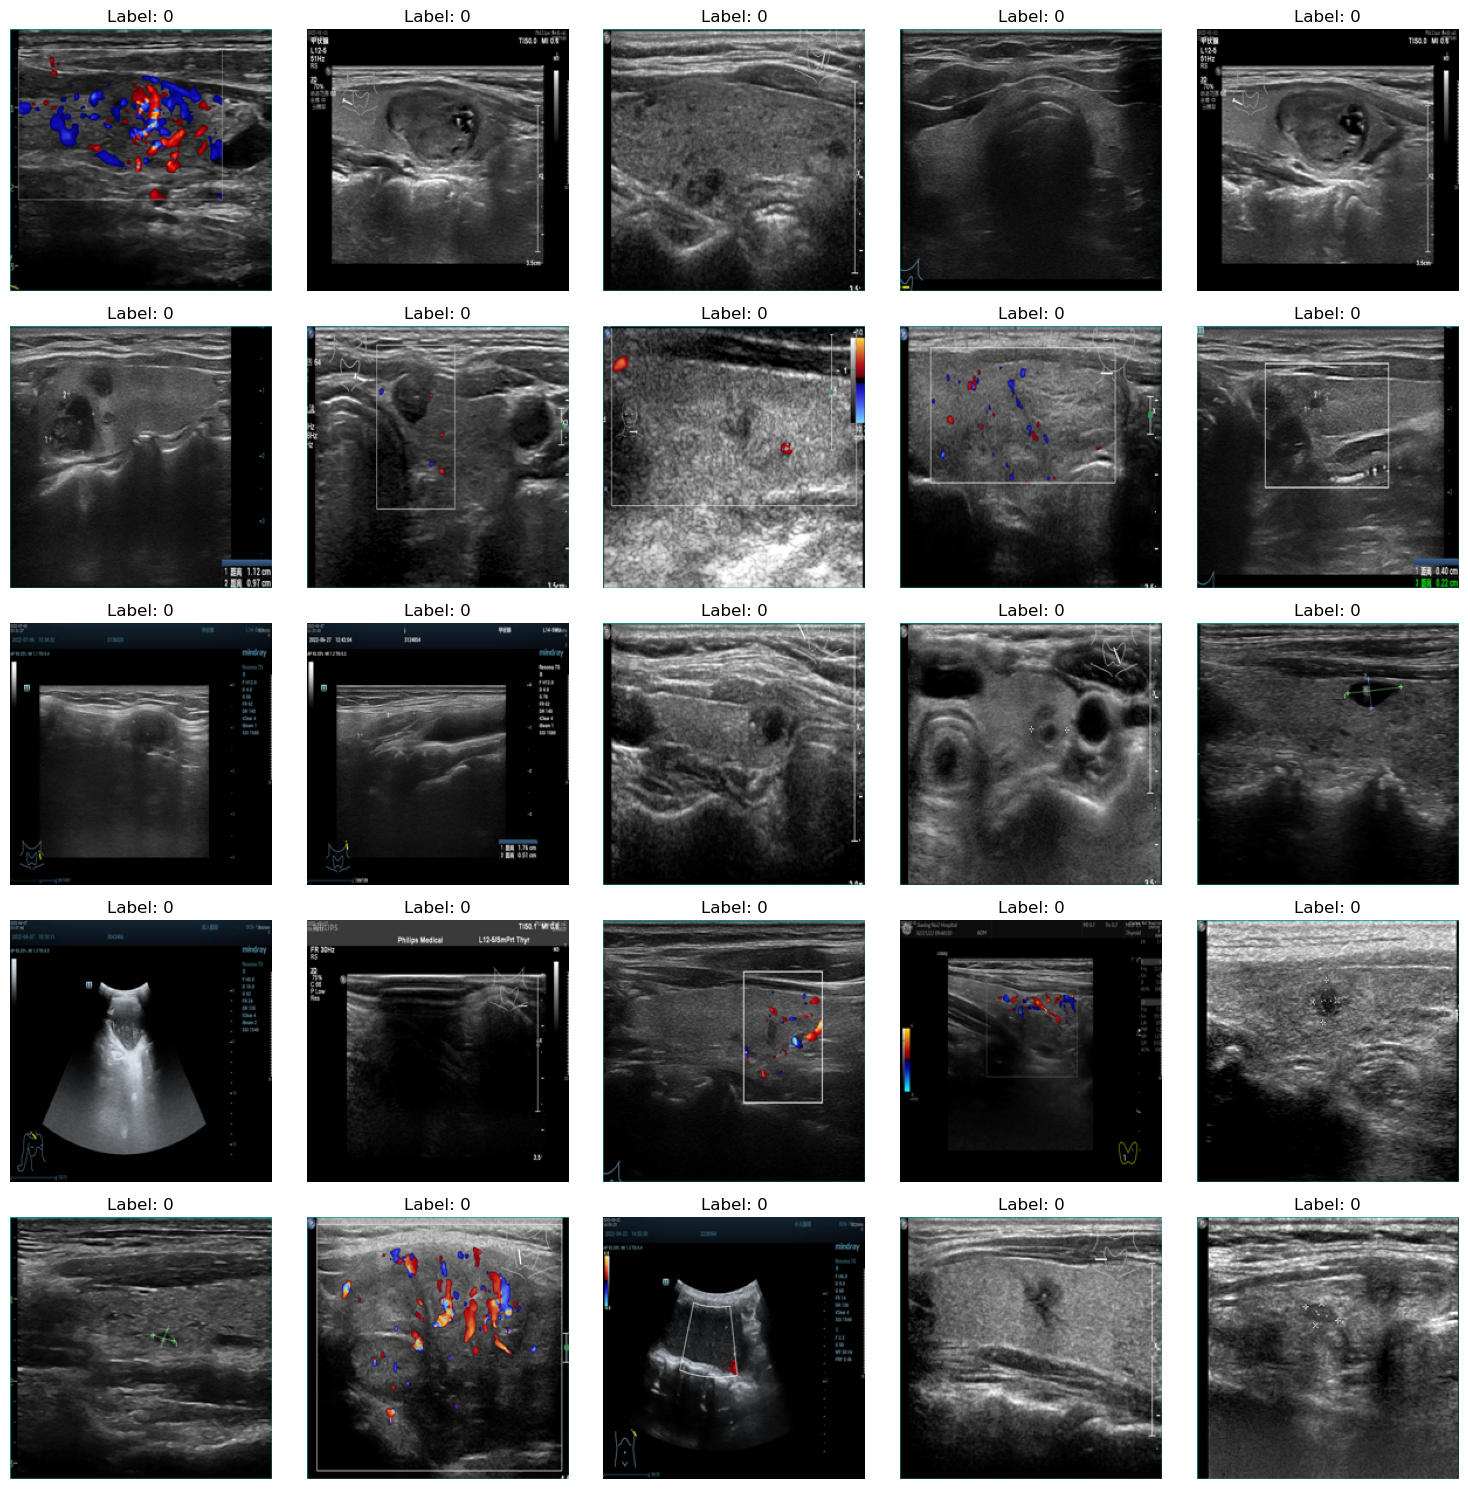

In [40]:
sample_image, sample_label = final_train_7030[1]  # This returns image, label tuple
sample_image = sample_image.permute(1, 2, 0)  
plt.imshow(sample_image)
plt.title(f"Label: {sample_label}")
plt.axis("off")
plt.show()

def show_images(dataset, start='start', batch_size=25):
    plt.figure(figsize=(15, 15))
    for i in range(start, min(start + batch_size, len(dataset))):
        img, label = dataset[i]
        img = img.permute(1, 2, 0)  # [C,H,W] → [H,W,C]
        
        plt.subplot(5, 5, i - start + 1)
        plt.imshow(img)
        plt.title(f"Label: {label}")
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()
show_images(final_train_7030, start=0)


In [41]:
# Function to convert PyTorch dataset to numpy arrays
def dataset_to_numpy(dataset):
    images = []
    labels = []
    for img, label in dataset:
        images.append(img.numpy())  # Convert tensor to numpy array
        labels.append(label.numpy())
    return np.array(images), np.array(labels)


X_train_7030, y_train_7030 = dataset_to_numpy(final_train_7030)
X_val_7030, y_val_7030 = dataset_to_numpy(combined_val_701515)

# Now X_train, y_train, X_val, and y_val are numpy arrays compatible with Keras

C:\Users\nalla\AppData\Local\Temp\ipykernel_23128\2180272878.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return image, torch.tensor(label, dtype=torch.long)


In [42]:
final_test_images_7030 = [cv2.resize(img, (224, 224)) for img in final_test_images_7030]
final_test_images_7030 = np.array(final_test_images_7030)
final_test_labels_7030 = np.array([int(x) for x in df_7030["label"]])
print(type(final_test_images_7030))
print(final_test_images_7030.shape)

<class 'numpy.ndarray'>
(1769, 224, 224, 3)


## CNN Model

In [76]:
# Build the model
cnnmodel_7030 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])
cnnmodel_7030.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
X_train_7030 = np.transpose(X_train_7030, (0, 2, 3, 1)) 
X_val_7030 = np.transpose(X_val_7030, (0, 2, 3, 1))  

history = cnnmodel_7030.fit(
    X_train_7030, y_train_7030,  
    validation_data=(X_val_7030, y_val_7030), 
    epochs=10,
    batch_size=32
)


Epoch 1/10
322/322 [==============================] - 178s 529ms/step - loss: 0.6874 - accuracy: 0.5445 - val_loss: 0.6634 - val_accuracy: 0.5708
Epoch 2/10
322/322 [==============================] - 155s 480ms/step - loss: 0.6098 - accuracy: 0.6457 - val_loss: 0.6049 - val_accuracy: 0.6579
Epoch 3/10
322/322 [==============================] - 154s 480ms/step - loss: 0.4655 - accuracy: 0.7693 - val_loss: 0.5313 - val_accuracy: 0.7332
Epoch 4/10
322/322 [==============================] - 154s 477ms/step - loss: 0.2961 - accuracy: 0.8725 - val_loss: 0.5384 - val_accuracy: 0.7967
Epoch 5/10
322/322 [==============================] - 154s 480ms/step - loss: 0.1766 - accuracy: 0.9301 - val_loss: 0.4231 - val_accuracy: 0.8630
Epoch 6/10
322/322 [==============================] - 155s 480ms/step - loss: 0.1068 - accuracy: 0.9614 - val_loss: 0.4587 - val_accuracy: 0.8975
Epoch 7/10
322/322 [==============================] - 153s 475ms/step - loss: 0.0707 - accuracy: 0.9746 - val_loss: 0.5720 -

In [79]:
# Save the model
cnnmodel_7030.save("cnnmodel7030_feature_extractor.h5")

C:\Users\nalla\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [43]:
cnnmodel = load_model("cnnmodel7030_feature_extractor.h5")

In [44]:
final_test_images_resized_7030 = [cv2.resize(img, (224, 224)) for img in final_test_images_7030]
final_test_images_resized_7030 = np.array(final_test_images_resized_7030)
y_preds = (cnnmodel.predict(final_test_images_resized_7030) > 0.5).astype("int32")
prediction_report=classification_report(final_test_labels_7030, y_preds)
print(prediction_report)

56/56 [==============================] - 6s 98ms/step
              precision    recall  f1-score   support

           0       0.81      0.88      0.84       665
           1       0.92      0.87      0.90      1104

    accuracy                           0.88      1769
   macro avg       0.86      0.88      0.87      1769
weighted avg       0.88      0.88      0.88      1769



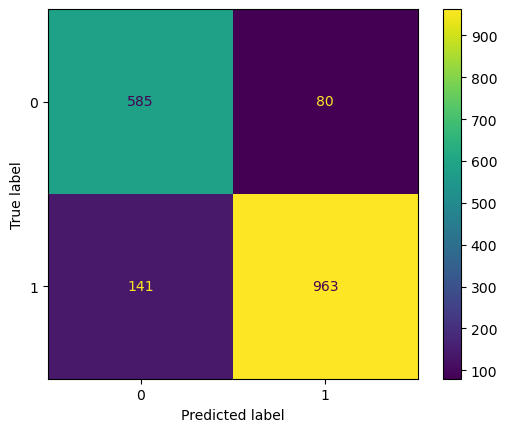

In [46]:
cm = confusion_matrix(final_test_labels_7030, y_preds)
ConfusionMatrixDisplay(cm).plot()


In [47]:
y_pred_probabs =cnnmodel.predict(final_test_images_resized_7030)

56/56 [==============================] - 6s 98ms/step


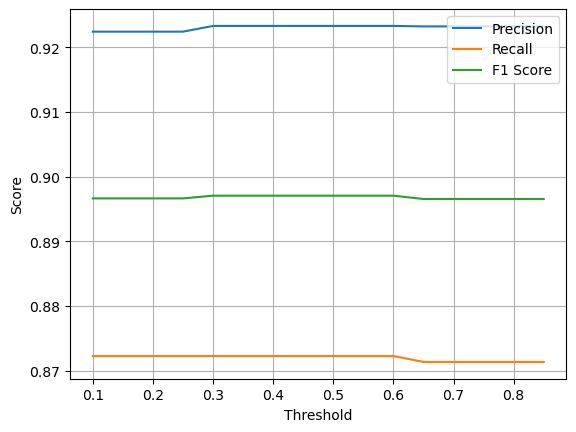

In [48]:
precisions, recalls, f1s = [], [], []
thresholds = np.arange(0.1, 0.9, 0.05)

for t in thresholds:
    preds = (y_pred_probabs > t).astype(int)
    precisions.append(precision_score(final_test_labels_7030, preds))
    recalls.append(recall_score(final_test_labels_7030, preds))
    f1s.append(f1_score(final_test_labels_7030, preds))

plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.plot(thresholds, f1s, label='F1 Score')
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.show()


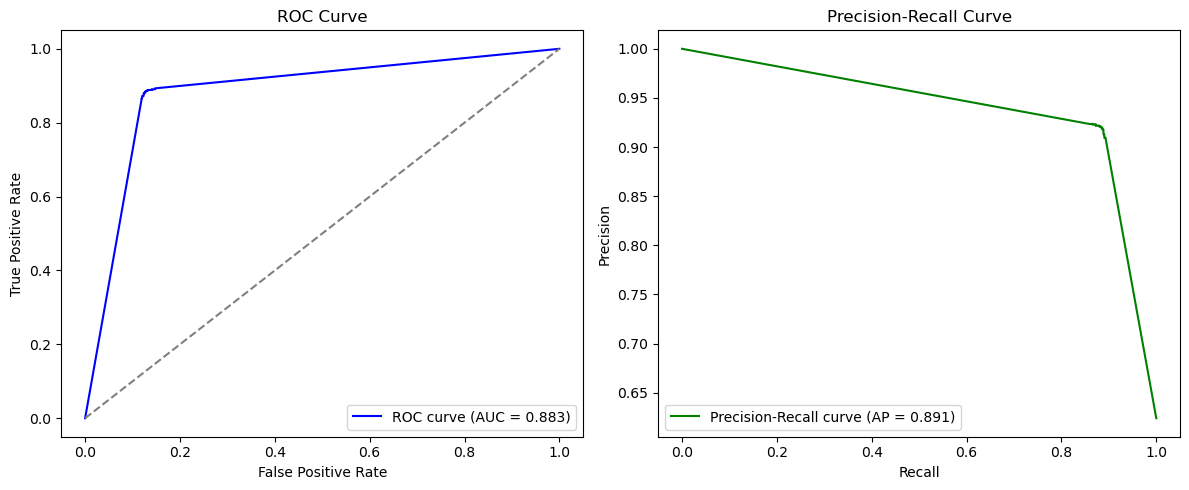

In [49]:
# Assuming you have:
# y_test (true binary labels)
# calibrated_test_probs (predicted probabilities for positive class)

# ROC Curve
fpr, tpr, _ = roc_curve(final_test_labels_7030, y_pred_probabs)
roc_auc = auc(fpr, tpr)

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(final_test_labels_7030, y_pred_probabs)
avg_precision = average_precision_score(final_test_labels_7030, y_pred_probabs)

plt.figure(figsize=(12, 5))

# Plot ROC
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')

# Plot Precision-Recall
plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='green', label=f'Precision-Recall curve (AP = {avg_precision:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')

plt.tight_layout()
plt.show()


# CNN-VIT Hybrid Model

In [34]:


# Load trained CNN model and extract features
cnn_model = tf.keras.models.load_model("cnnmodel7030_feature_extractor.h5")
feature_extractor = tf.keras.Model(
    inputs=cnn_model.input,
    outputs=cnn_model.get_layer("dense_4").output
)
feature_extractor.trainable = False

# Load and freeze ViT model
vit_model = TFViTModel.from_pretrained("google/vit-base-patch16-224-in21k")
vit_model.trainable = False

# Input layer
input_layer = tf.keras.Input(shape=(224, 224, 3))

# CNN branch
cnn_features = feature_extractor(input_layer)  # (None, 128)

# ViT branch
rescaled = tf.keras.layers.Rescaling(1./255)(input_layer)
vit_transposed = tf.transpose(rescaled, perm=[0, 3, 1, 2])
vit_outputs = vit_model(vit_transposed, training=False)  # Already expects shape (B, H, W, C)
vit_pooled = tf.keras.layers.GlobalAveragePooling1D()(vit_outputs.last_hidden_state)  # (None, 768)

# Combine features
concat = tf.keras.layers.Concatenate()([cnn_features, vit_pooled])  # (None, 896)

# Dense head
x = tf.keras.layers.Dense(256, activation='relu')(concat)
x = tf.keras.layers.Dropout(0.4)(x)  # Increased dropout for generalization
output = tf.keras.layers.Dense(1, activation='sigmoid')(x)

# Final model
cnnvithybrid_model_7030 = tf.keras.Model(inputs=input_layer, outputs=output)
cnnvithybrid_model_7030.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=0.05),
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)


All PyTorch model weights were used when initializing TFViTModel.

All the weights of TFViTModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTModel for predictions without further training.


In [32]:
X_train_7030 = X_train_7030.transpose(0, 2, 3, 1)
X_val_7030 = X_val_7030.transpose(0, 2, 3, 1)


In [35]:
history = cnnvithybrid_model_7030.fit(
     X_train_7030, y_train_7030,
     validation_data=(X_val_7030, y_val_7030),
     epochs=1,
     batch_size=32
)


322/322 [==============================] - 1855s 6s/step - loss: 0.2939 - accuracy: 0.9217 - auc: 0.9734 - val_loss: 0.1973 - val_accuracy: 0.9755 - val_auc: 0.9921


In [27]:
cnnvithybrid_model_7030.compile(loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC()])
final_test_labels_7030_reshaped = final_test_labels_7030.reshape(-1, 1)


In [39]:
y_pred_probs = cnnvithybrid_model_7030.predict(final_test_images_7030)
y_pred = (y_pred_probs > 0.2).astype(int).flatten()
y_true = final_test_labels_7030_reshaped
print(classification_report(y_true, y_pred, digits=4))


56/56 [==============================] - 314s 5s/step
              precision    recall  f1-score   support

           0     0.7673    0.8526    0.8077       665
           1     0.9049    0.8442    0.8735      1104

    accuracy                         0.8474      1769
   macro avg     0.8361    0.8484    0.8406      1769
weighted avg     0.8531    0.8474    0.8487      1769



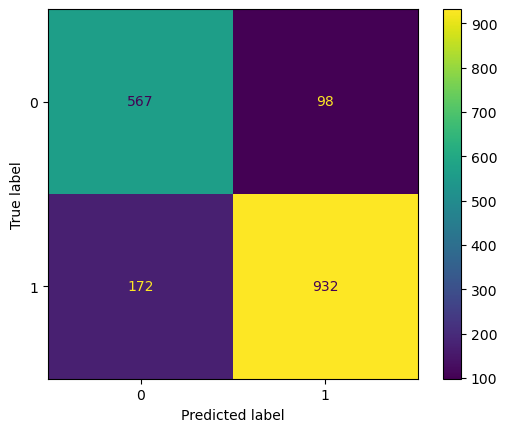

In [84]:
cm = confusion_matrix(final_test_labels_7030_reshaped, y_pred)
ConfusionMatrixDisplay(cm).plot()


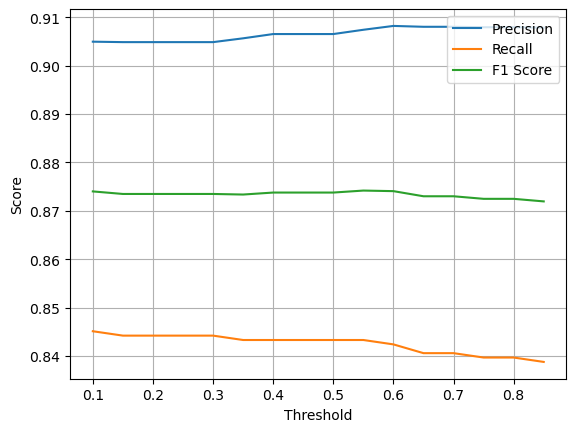

In [80]:
precisions, recalls, f1s = [], [], []
thresholds = np.arange(0.1, 0.9, 0.05)
for t in thresholds:
    preds = (y_pred_probs > t).astype(int)
    precisions.append(precision_score(final_test_labels_7030, preds))
    recalls.append(recall_score(final_test_labels_7030, preds))
    f1s.append(f1_score(final_test_labels_7030, preds))

plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.plot(thresholds, f1s, label='F1 Score')
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.show()


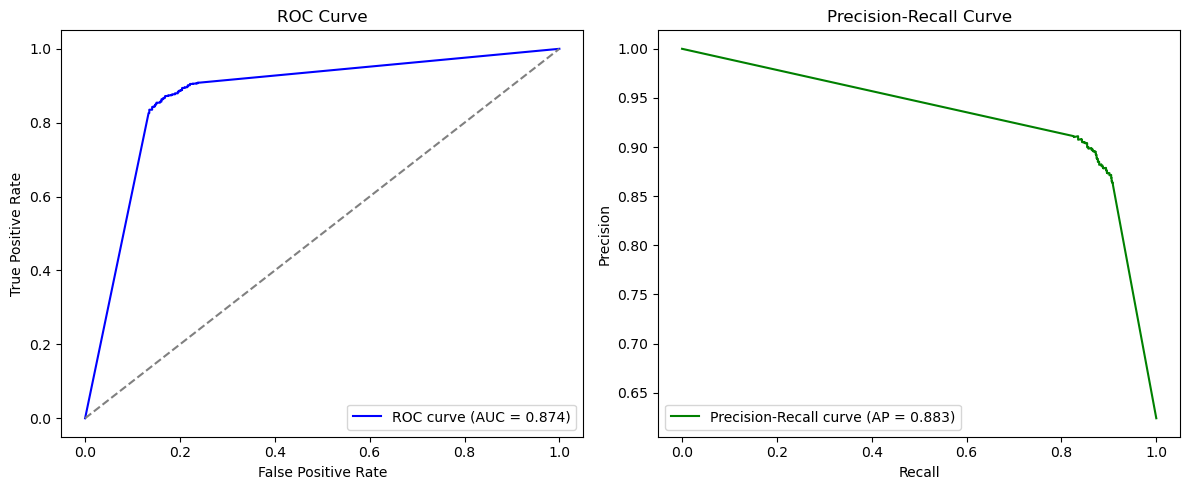

In [94]:


# Assuming you have:
# y_test (true binary labels)
# calibrated_test_probs (predicted probabilities for positive class)

# ROC Curve
fpr, tpr, _ = roc_curve(final_test_labels_7030, y_pred_probs)
roc_auc = auc(fpr, tpr)

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(final_test_labels_7030, y_pred_probs)
avg_precision = average_precision_score(final_test_labels_7030, y_pred_probs)

plt.figure(figsize=(12, 5))

# Plot ROC
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')

# Plot Precision-Recall
plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='green', label=f'Precision-Recall curve (AP = {avg_precision:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')

plt.tight_layout()
plt.show()


In [40]:
cnnvithybrid_model_7030.save("cnnvithybrid_model_7030.h5")


C:\Users\nalla\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [41]:

cnnvit_model= load_model("cnnvithybrid_model_7030.h5", custom_objects={"TFViTModel": TFViTModel})




In [126]:
cnnmodel.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 111, 111, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 26, 26, 128)      

# InceptionV3 Model

In [90]:
#  Resize images to (139, 139), convert to float16 & normalize
X_train_resized = np.array([cv2.resize(img, (139, 139)) for img in X_train_7030]).astype('float16') / 255.0
X_val_resized   = np.array([cv2.resize(img, (139, 139)) for img in X_val_7030]).astype('float16') / 255.0


# Image augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)
datagen.fit(X_train_resized)

# Load InceptionV3 base model
base_model_inv = InceptionV3(weights='imagenet', include_top=False, input_shape=(139, 139, 3))
base_model_inv.trainable = True
for layer in base_model_inv.layers[:-50]:  # Freeze all layers except last 50
    layer.trainable = False

# Add classification head
x = GlobalAveragePooling2D()(base_model_inv.output)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

model_incep = Model(inputs=base_model_inv.input, outputs=output)

# Compile
model_incep.compile(optimizer=Adam(learning_rate=1e-4),
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

# Handle class imbalance
weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train_7030), y=y_train_7030)
class_weights = {i: w for i, w in enumerate(weights)}

# Train
history = model_incep.fit(
    datagen.flow(X_train_resized, y_train_7030, batch_size=32),
    validation_data=(X_val_resized, y_val_7030),
    epochs=25,
    class_weight=class_weights
)

# Evaluate


Epoch 1/25
322/322 [==============================] - 101s 277ms/step - loss: 0.6972 - accuracy: 0.5146 - val_loss: 0.6949 - val_accuracy: 0.5045
Epoch 2/25
322/322 [==============================] - 98s 305ms/step - loss: 0.6939 - accuracy: 0.5022 - val_loss: 0.7002 - val_accuracy: 0.5082
Epoch 3/25
322/322 [==============================] - 104s 321ms/step - loss: 0.6927 - accuracy: 0.5079 - val_loss: 0.6921 - val_accuracy: 0.5073
Epoch 4/25
322/322 [==============================] - 107s 333ms/step - loss: 0.6927 - accuracy: 0.5152 - val_loss: 0.6924 - val_accuracy: 0.5009
Epoch 5/25
322/322 [==============================] - 103s 320ms/step - loss: 0.6924 - accuracy: 0.5126 - val_loss: 0.7063 - val_accuracy: 0.5082
Epoch 6/25
322/322 [==============================] - 108s 334ms/step - loss: 0.6905 - accuracy: 0.5133 - val_loss: 0.6910 - val_accuracy: 0.5200
Epoch 7/25
322/322 [==============================] - 114s 353ms/step - loss: 0.6910 - accuracy: 0.5193 - val_loss: 0.6904 - 

C:\Users\nalla\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nalla\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nalla\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [92]:
model_incep.save("inceptionv3model.h5")

C:\Users\nalla\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [104]:
x_test_resized = np.array([cv2.resize(img, (139, 139)) for img in final_test_images_7030]).astype('float16') / 255.0
y_pred_incep = (model_incep.predict(x_test_resized) > 0.5).astype('int32')
print(classification_report(final_test_labels_7030_reshaped, y_pred_incep))

56/56 [==============================] - 10s 168ms/step
              precision    recall  f1-score   support

           0       0.40      0.56      0.47       665
           1       0.65      0.50      0.57      1104

    accuracy                           0.52      1769
   macro avg       0.53      0.53      0.52      1769
weighted avg       0.56      0.52      0.53      1769



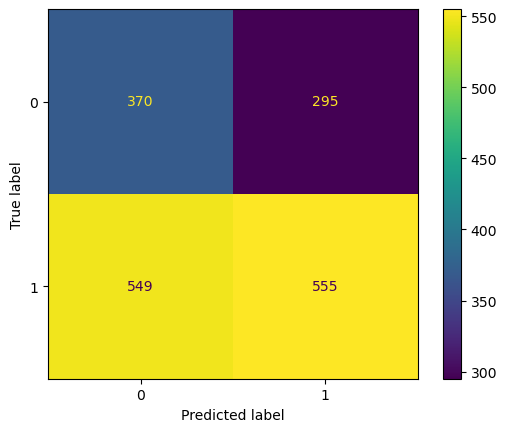

In [105]:
cm = confusion_matrix(final_test_labels_7030_reshaped, y_pred_incep)
ConfusionMatrixDisplay(cm).plot()


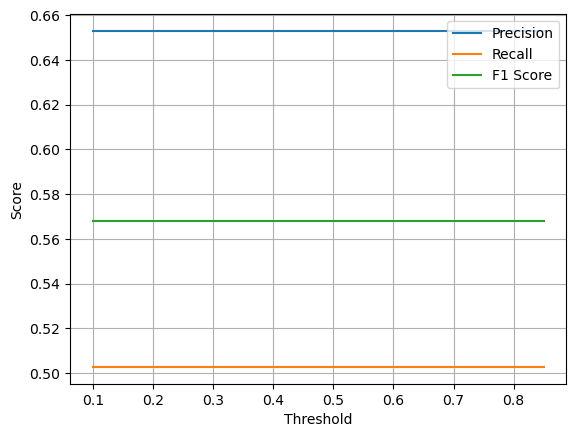

In [106]:
precisions, recalls, f1s = [], [], []
thresholds = np.arange(0.1, 0.9, 0.05)
for t in thresholds:
    preds = (y_pred_incep > t).astype(int)
    precisions.append(precision_score(final_test_labels_7030, preds))
    recalls.append(recall_score(final_test_labels_7030, preds))
    f1s.append(f1_score(final_test_labels_7030, preds))

plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.plot(thresholds, f1s, label='F1 Score')
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.show()


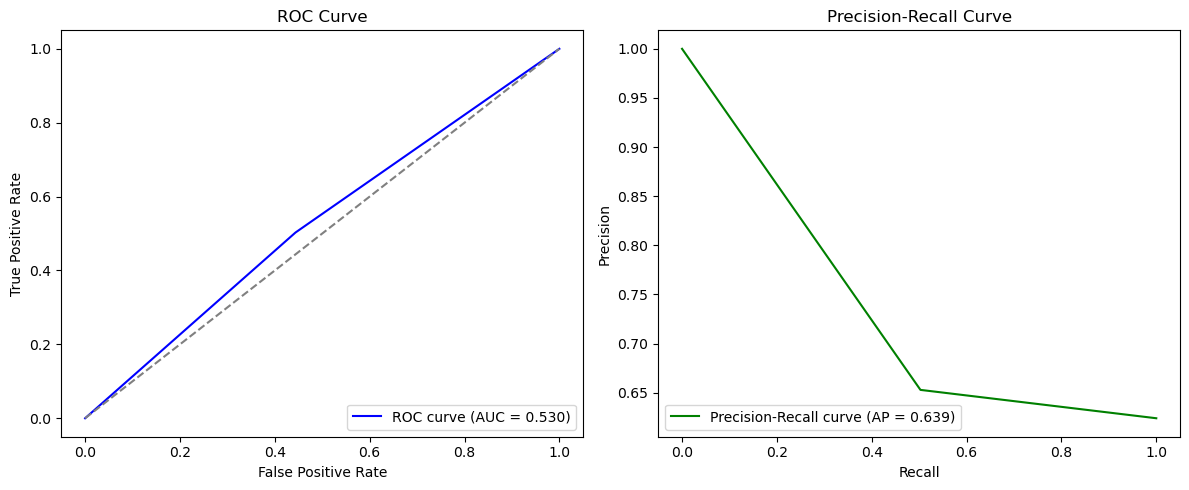

In [107]:


# Assuming you have:
# y_test (true binary labels)
# calibrated_test_probs (predicted probabilities for positive class)

# ROC Curve
fpr, tpr, _ = roc_curve(final_test_labels_7030, y_pred_incep)
roc_auc = auc(fpr, tpr)

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(final_test_labels_7030, y_pred_incep)
avg_precision = average_precision_score(final_test_labels_7030, y_pred_incep)

plt.figure(figsize=(12, 5))

# Plot ROC
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')

# Plot Precision-Recall
plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='green', label=f'Precision-Recall curve (AP = {avg_precision:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')

plt.tight_layout()
plt.show()


# VGG16 Model

In [91]:


# Resize to (224, 224) for VGG16 compatibility
X_train_resized = np.array([cv2.resize(img, (224, 224)) for img in X_train_7030]).astype('float16') / 255.0
X_val_resized = np.array([cv2.resize(img, (224, 224)) for img in X_val_7030]).astype('float16') / 255.0

# Load VGG16 base
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base

#  Add classifier head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

model_vgg = Model(inputs=base_model.input, outputs=output)
model_vgg.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# Train
model_vgg.fit(X_train_resized, y_train_7030,
              validation_data=(X_val_resized, y_val_7030),
              epochs=10,
              batch_size=32)

# Evaluate
y_pred_vgg = (model_vgg.predict(X_val_resized) > 0.5).astype("int32")
print(classification_report(y_val_7030, y_pred_vgg))


Epoch 1/10
322/322 [==============================] - 640s 2s/step - loss: 0.7167 - accuracy: 0.5099 - val_loss: 0.6939 - val_accuracy: 0.5000
Epoch 2/10
322/322 [==============================] - 630s 2s/step - loss: 0.7037 - accuracy: 0.4941 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 3/10
322/322 [==============================] - 627s 2s/step - loss: 0.6986 - accuracy: 0.4991 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 4/10
322/322 [==============================] - 626s 2s/step - loss: 0.6971 - accuracy: 0.4863 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 5/10
322/322 [==============================] - 624s 2s/step - loss: 0.6946 - accuracy: 0.4925 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 6/10
322/322 [==============================] - 623s 2s/step - loss: 0.6940 - accuracy: 0.5026 - val_loss: 0.6933 - val_accuracy: 0.5000
Epoch 7/10
322/322 [==============================] - 621s 2s/step - loss: 0.6943 - accuracy: 0.4936 - val_loss: 0.6932 - val_accuracy: 0.5000

C:\Users\nalla\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nalla\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nalla\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [93]:
model_vgg.save("vggmodel.h5")

C:\Users\nalla\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [115]:
x_test_resized = np.array([cv2.resize(img, (139, 139)) for img in final_test_images_7030]).astype('float16') / 255.0
y_pred_vgg = (model_vgg.predict(x_test_resized) > 0.5).astype('int32')
print(classification_report(final_test_labels_7030_reshaped, y_pred_vgg))

56/56 [==============================] - 35s 615ms/step
              precision    recall  f1-score   support

           0       0.44      0.19      0.27       665
           1       0.64      0.86      0.73      1104

    accuracy                           0.61      1769
   macro avg       0.54      0.52      0.50      1769
weighted avg       0.56      0.61      0.56      1769



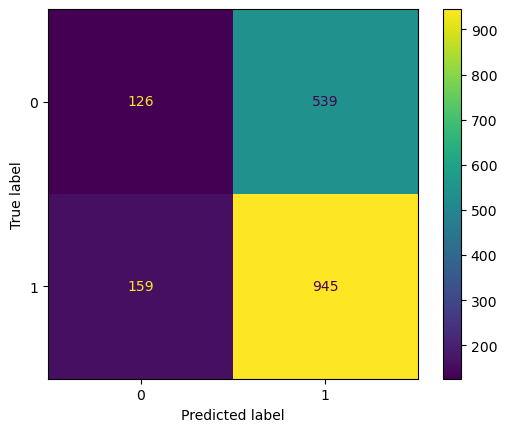

In [116]:
cm = confusion_matrix(final_test_labels_7030_reshaped, y_pred_vgg)
ConfusionMatrixDisplay(cm).plot()


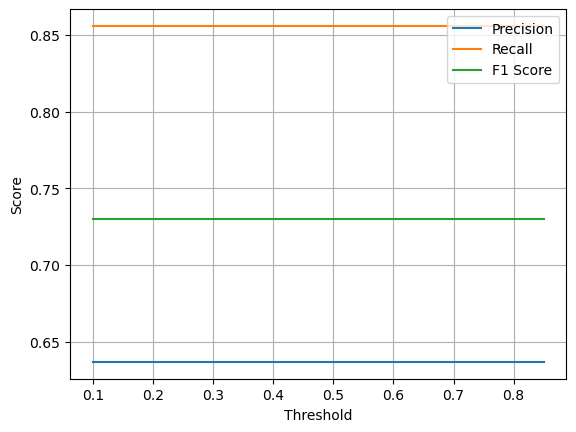

In [117]:
precisions, recalls, f1s = [], [], []
thresholds = np.arange(0.1, 0.9, 0.05)
for t in thresholds:
    preds = (y_pred_vgg> t).astype(int)
    precisions.append(precision_score(final_test_labels_7030, preds))
    recalls.append(recall_score(final_test_labels_7030, preds))
    f1s.append(f1_score(final_test_labels_7030, preds))

plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.plot(thresholds, f1s, label='F1 Score')
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.show()


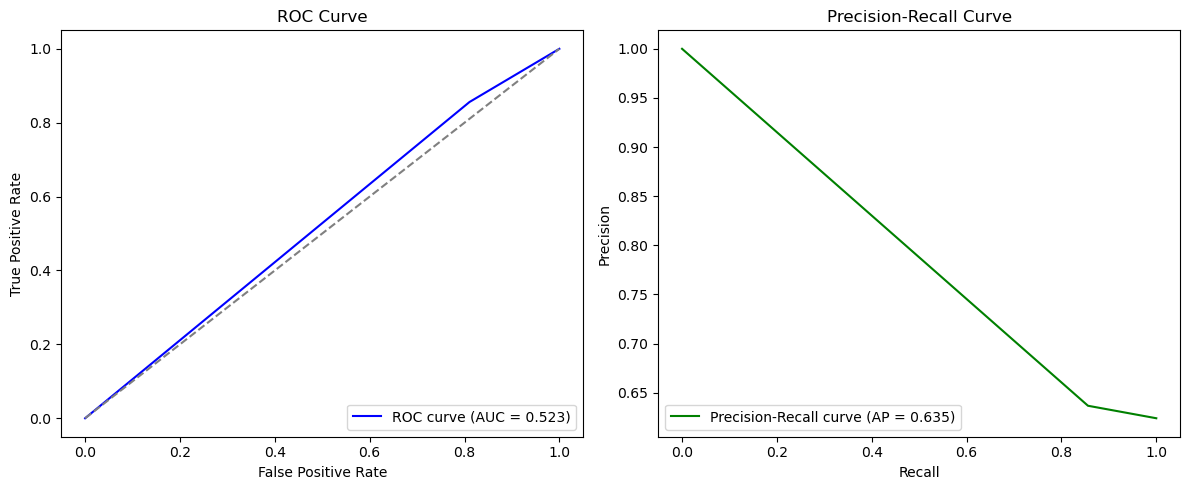

In [118]:


# Assuming you have:
# y_test (true binary labels)
# calibrated_test_probs (predicted probabilities for positive class)

# ROC Curve
fpr, tpr, _ = roc_curve(final_test_labels_7030, y_pred_vgg)
roc_auc = auc(fpr, tpr)

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(final_test_labels_7030, y_pred_vgg)
avg_precision = average_precision_score(final_test_labels_7030, y_pred_vgg)

plt.figure(figsize=(12, 5))

# Plot ROC
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')

# Plot Precision-Recall
plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='green', label=f'Precision-Recall curve (AP = {avg_precision:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')

plt.tight_layout()
plt.show()


# Accuracy and F1 Score Comparision

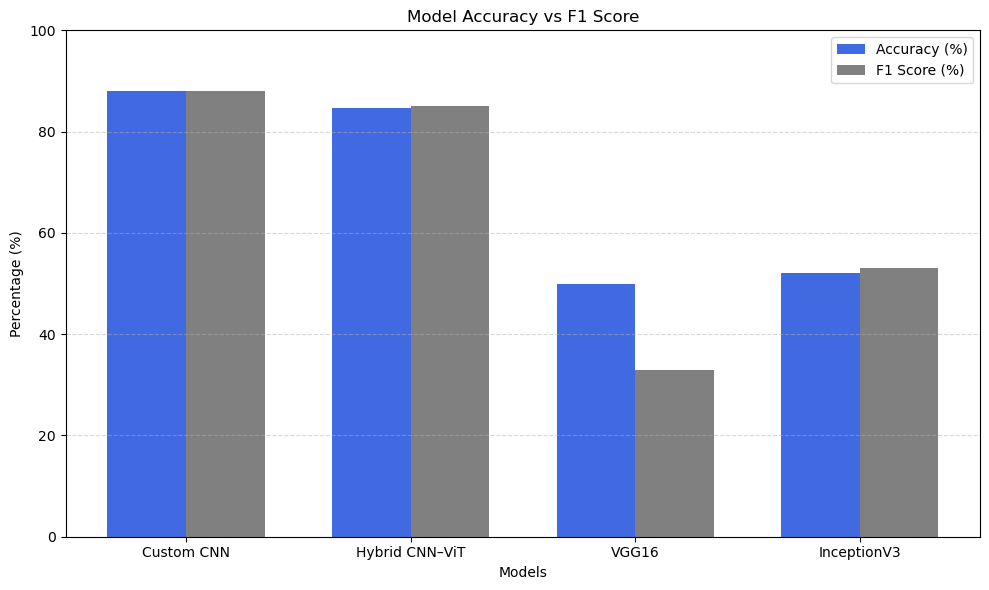

In [62]:
models = ["Custom CNN", "Hybrid CNN–ViT", "VGG16", "InceptionV3"]
accuracies = [88, 84.7, 50, 52]         
f1_scores = [0.88, 0.85, 0.33, 0.53]    

x = range(len(models))
bar_width = 0.35

plt.figure(figsize=(10, 6))
plt.bar(x, accuracies, width=bar_width, label='Accuracy (%)', color='royalblue')
plt.bar([i + bar_width for i in x], [f * 100 for f in f1_scores], width=bar_width, label='F1 Score (%)', color='gray')

plt.xlabel('Models')
plt.ylabel('Percentage (%)')
plt.title('Model Accuracy vs F1 Score')
plt.xticks([i + bar_width / 2 for i in x], models)
plt.ylim(0, 100)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()
